In [113]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [114]:
#importing all the required packages
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import os

In [115]:
#Reading the data from the Kaggle competiton
data_path = '../input/csc4851-homework4/birds_400'  
train_classes = os.listdir(data_path + "/train")

In [116]:
import torchvision.transforms as tt
#initialising the stats value w
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
trains = tt.Compose([tt.RandomCrop(224, padding=15, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])   
valids = tt.Compose([tt.ToTensor(),
                         tt.Normalize(*stats)])

In [117]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
#reading the training Dataset
traing_dataset = ImageFolder(data_path+'/train', trains)
#reading the validation Dataset
validation_dataset = ImageFolder(data_path+'/valid', valids) 
#reading the testing Dataset
testing_dataset = ImageFolder(data_path+'/test', valids) 

# print(traing_dataset)
# print(validation_dataset)

In [118]:
def dataset_info(dataset):
    img, label = dataset[0]

dataset_info(traing_dataset)
dataset_info(validation_dataset)
dataset_info(testing_dataset)

In [119]:
from tqdm import tqdm
from cv2 import imread
import os
def count(dataset_path,dataset_type):
    #initialising the length
    species = len(os.listdir(dataset_path))
    #initialising with empty list for species_names
    species_names = []
    #initialising with empty list for species_image
    species_image = []
    #initialising with empty list for widths and heights
    width = []
    ht = []
    
    for i in tqdm(os.listdir(dataset_path)):
        #for each species Appending the item in the species name 
        species_names.append(i)
        species_folder = dataset_path + "/" + i + "/"
        species_image.append(len(os.listdir(species_folder)))
        for j in os.listdir(species_folder):
            file = species_folder + j
            img = imread(file)
            width.append(img.shape[1])
            ht.append(img.shape[0])
    return species_names,species_image,ht,width

In [120]:
trainingSpeciesNames,trainSpeciesImageCount,trainImagesHeights,trainImagesWidths = count(dataset_path=data_path+"/train/",dataset_type="train")

100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


In [121]:
validationSpeciesNames,validationSpeciesImageCount,validationImagesHeights,validationImagesWidths = count(dataset_path=data_path+"/valid",dataset_type="validation")

100%|██████████| 400/400 [00:04<00:00, 86.52it/s]


In [122]:
testSpeciesNames,testingSpeciesImageCount,testingImagesHeights,testImagesWidths = count(dataset_path=data_path+"/test/",dataset_type="test")

100%|██████████| 400/400 [00:04<00:00, 91.50it/s]


In [123]:
check = sorted(trainingSpeciesNames) == sorted(validationSpeciesNames) == sorted(testSpeciesNames)

In [124]:
for itern in trainingSpeciesNames:
    
    if (itern not in validationSpeciesNames) or (itern not in testSpeciesNames):
        print(itern)

set(trainingSpeciesNames).difference(set(validationSpeciesNames))
set(validationSpeciesNames).difference(set(trainingSpeciesNames))
set(testSpeciesNames).difference(set(trainingSpeciesNames))

BLACK & YELLOW  BROADBILL


{'BLACK & YELLOW BROADBILL'}

In [125]:
os.rename(src=data_path+"/train/BLACK & YELLOW  BROADBILL",dst=data_path+"/train/BLACK & YELLOW BROADBILL")

OSError: [Errno 30] Read-only file system: '../input/csc4851-homework4/birds_400/train/BLACK & YELLOW  BROADBILL' -> '../input/csc4851-homework4/birds_400/train/BLACK & YELLOW BROADBILL'

Text(0.5, 0, 'Width')

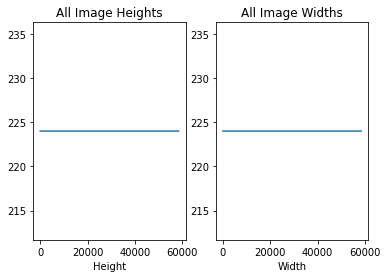

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplot(1,2,1)
sns.lineplot(data=trainImagesHeights)
plt.title("All Image Heights")
plt.xlabel("Height")

plt.subplot(1,2,2)
sns.lineplot(data=trainImagesWidths)
plt.title("All Image Widths")
plt.xlabel("Width")

In [127]:
imgSiz = [224, 224]

In [128]:
trainingDir = '../input/csc4851-homework4/birds_400/train'
validationPath = '../input/csc4851-homework4/birds_400/valid'
testingPath = '../input/csc4851-homework4/birds_400/test'

In [129]:
xcept = Xception(input_shape = imgSiz + [3], weights='imagenet', include_top=False)

In [130]:
for plane in xcept.layers:
    plane.trainable = False

dirs = glob('../input/csc4851-homework4/birds_400/train/*')
xnptn = Flatten()(xcept.output)

xnptn = layers.Dense(256, 'relu', kernel_initializer='he_normal')(xnptn)
xnptn = layers.BatchNormalization()(xnptn)
xnptn = layers.Dropout(0.3)(xnptn)

prediction = Dense(len(dirs), activation='softmax')(xnptn)

model = Model(inputs=xcept.input, outputs=prediction)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [131]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [132]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainingDataGeneratiom = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

testingDataGeneration = ImageDataGenerator(rescale = 1./255)

validationDatageneration = ImageDataGenerator(rescale = 1./255)

trainingDataa = trainingDataGeneratiom.flow_from_directory('../input/csc4851-homework4/birds_400/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
validationSett = validationDatageneration.flow_from_directory('../input/csc4851-homework4/birds_400/valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

testingSett = testingDataGeneration.flow_from_directory('../input/csc4851-homework4/birds_400/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [133]:
r = model.fit(trainingDataa,validation_data=validationSett,epochs=10,steps_per_epoch=len(testingSett),validation_steps=len(validationSett))

Epoch 1/10
63/63 [==============================] - 36s 526ms/step - loss: 0.6769 - accuracy: 0.0025 - val_loss: 0.6443 - val_accuracy: 0.0060
Epoch 2/10
63/63 [==============================] - 33s 519ms/step - loss: 0.2994 - accuracy: 0.0055 - val_loss: 0.1347 - val_accuracy: 0.0055
Epoch 3/10
63/63 [==============================] - 32s 510ms/step - loss: 0.0657 - accuracy: 0.0084 - val_loss: 0.0417 - val_accuracy: 0.0270
Epoch 4/10
63/63 [==============================] - 32s 513ms/step - loss: 0.0304 - accuracy: 0.0159 - val_loss: 0.0235 - val_accuracy: 0.0560
Epoch 5/10
63/63 [==============================] - 32s 509ms/step - loss: 0.0226 - accuracy: 0.0317 - val_loss: 0.0186 - val_accuracy: 0.0735
Epoch 6/10
63/63 [==============================] - 36s 571ms/step - loss: 0.0195 - accuracy: 0.0486 - val_loss: 0.0177 - val_accuracy: 0.0865
Epoch 7/10
63/63 [==============================] - 32s 504ms/step - loss: 0.0181 - accuracy: 0.0675 - val_loss: 0.0186 - val_accuracy: 0.1075

In [134]:
model.evaluate(testingSett)

63/63 [==============================] - 7s 102ms/step - loss: 0.0402 - accuracy: 0.1595


[0.04015478864312172, 0.15950000286102295]

In [135]:
def plot_accuracies(hist):
    accuracies = [x['val_accuracy'] for x in hist]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [136]:
import tensorflow as tf
from keras.models import load_model
model.save('xception.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


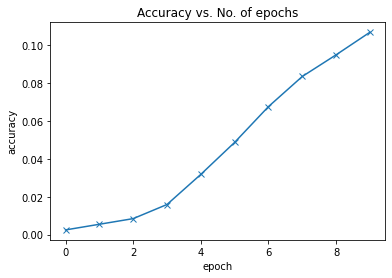

In [137]:
accuracies=r.history['accuracy']
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Text(0.5, 1.0, 'Loss vs. No. of epochs')

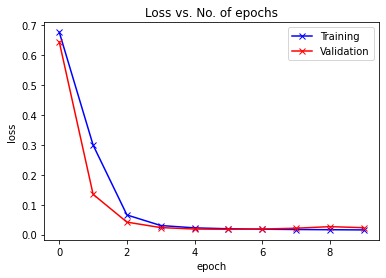

In [138]:
train_losses = r.history['loss']
val_losses = r.history['val_loss']
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')

In [139]:
from sklearn.metrics import log_loss
from keras import losses
from glob import glob
from keras.preprocessing import image
def prepare(imgDir):
    img = image.load_img(imgDir, target_size=(224,224))
    k = image.img_to_array(img)
    k = k/224
    return np.expand_dims(k, axis=0)
ccet = losses.CategoricalCrossentropy()

In [140]:
skltn = [0]*400
logLoss = {}
test_images = glob("/kaggle/input/csc4851-homework4/birds_400/test/" + "*/*.jpg")

for path in test_images:
    result = model.predict([prepare(path)])
    actual_class = path.split('/')[-2]
    actual_class = "BLACK & YELLOW  BROADBILL" if actual_class == "BLACK & YELLOW BROADBILL" else actual_class
    actual_index = train_classes.index(actual_class)
    skltn[actual_index] = 1
    log_loss_current = ccet(skltn, result[0]).numpy()
    if actual_index in logLoss:
        logLoss[actual_index] += (log_loss_current)/100
    else:
        logLoss[actual_index] = (log_loss_current)/100
    skltn[actual_index] = 0

In [141]:
logLoss

{0: 0.3277486848831177,
 1: 0.3479021406173706,
 2: 0.3073071336746216,
 3: 0.2774872493743897,
 4: 0.3239929914474487,
 5: 0.28964179039001464,
 6: 0.3098733472824097,
 7: 0.3072060060501099,
 8: 0.326571831703186,
 9: 0.31538286685943606,
 10: 0.3441450548171997,
 11: 0.2954118824005127,
 12: 0.31048469066619877,
 13: 0.3226835012435913,
 14: 0.3153414011001587,
 15: 0.2864887428283691,
 16: 0.3295176315307617,
 17: 0.36491816520690923,
 18: 0.33666467666625977,
 19: 0.2878622817993164,
 20: 0.30317943572998046,
 21: 0.31449737548828127,
 22: 0.33816330909729,
 23: 0.3220683097839356,
 24: 0.38824981689453125,
 25: 0.13141228437423708,
 26: 0.3148446941375732,
 27: 0.29762919902801516,
 28: 0.33101097106933597,
 29: 0.32369020938873294,
 30: 0.30800311088562016,
 31: 0.3074330234527588,
 32: 0.2721736431121826,
 33: 0.3203693151473999,
 34: 0.31289310455322267,
 35: 0.2795880794525147,
 36: 0.3148581600189209,
 37: 0.337244815826416,
 38: 0.29717220783233644,
 39: 0.29132029533386233

In [142]:
import csv
ids = list(logLoss.keys())
values = list(logLoss.values())
f = open('submission.csv', 'w')
writer = csv.writer(f)
writer.writerow(['id','birds'])
for index in range(len(ids)):
    writer.writerow([ids[index],values[index]])

In [143]:
ls

__notebook_source__.ipynb  submission.csv  xception.h5
